<a href="https://colab.research.google.com/github/geoffwoollard/prob_prog/blob/main/project/pyro_gaussian_unknown_mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip3 install pyro-ppl 

     |████████████████████████████████| 678 kB 7.0 MB/s 


# Tutorial
* http://pyro.ai/examples/intro_part_ii.html

In [20]:
import pyro
import torch
import matplotlib.pyplot as plt

pyro.set_rng_seed(101)


In [127]:
def scale(guess): # the forward model. takes the same inpute as the guide
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))
    
conditioned_scale = pyro.condition(scale, data={"measurement": torch.tensor(9.5)}) # the observe statements


In [128]:
import pyro.distributions as dist

def scale_parametrized_guide(guess): # the proposal distribution
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b))) # weight has same form as in scale

In [129]:
guess = 8.5 # important matches conditioned_scale

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale, # takes in guess, returns sample of weight
                     guide=scale_parametrized_guide, # takes in guess, returns sample of weight
                     optim=pyro.optim.Adam({"lr": 0.003}), # the optimizer
                     loss=pyro.infer.Trace_ELBO()) # the objective to optimize

a =  9.140591621398926
b =  0.592543363571167


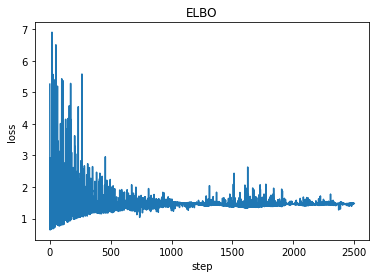

In [130]:
losses, a, b = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

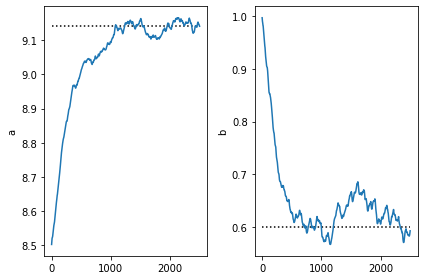

In [131]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

# extend example
`mu` <-> `weight`
`lik` <-> `measurement`

In [122]:
import pyro
import torch
import matplotlib.pyplot as plt

pyro.set_rng_seed(101)


In [136]:
def scale(guess): # the forward model. takes the same inpute as the guide
    mu = pyro.sample("mu", dist.Normal(guess, 1.0))
    return pyro.sample("lik", dist.Normal(mu, 0.75))
    
conditioned_scale = pyro.condition(scale, data={"lik": torch.tensor(9.5)}) # the observe statements


In [137]:
import pyro.distributions as dist

def scale_parametrized_guide(guess): # the proposal distribution
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("mu", dist.Normal(a, torch.abs(b))) # weight has same form as in scale

In [138]:
guess = 8.5 # important matches conditioned_scale

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale, # takes in guess, returns sample of weight
                     guide=scale_parametrized_guide, # takes in guess, returns sample of weight
                     optim=pyro.optim.Adam({"lr": 0.003}), # the optimizer
                     loss=pyro.infer.Trace_ELBO()) # the objective to optimize

a =  9.113338470458984
b =  0.6174644231796265


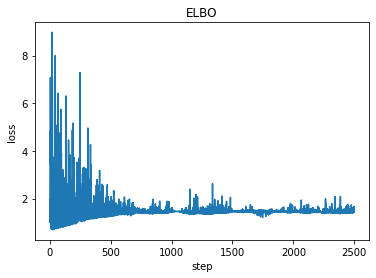

In [139]:
losses, a, b = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

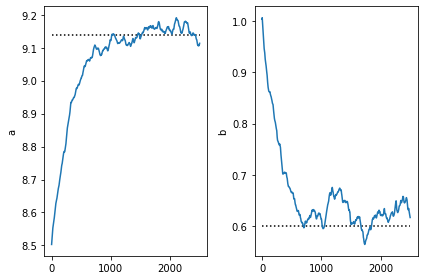

In [140]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

# Gaussian unknown mean problem (with only one observe)

For now I only know how to incorporate one observe, so hte observe lik 9 line has been removed from the original problem.

* https://www.cs.ubc.ca/~fwood/CS532W-539W/homework/2.html
* https://www.cs.ubc.ca/~fwood/CS532W-539W/homework/4.html
```
(let [mu (sample (normal 1 (sqrt 5)))
           sigma (sqrt 2)
           lik (normal mu sigma)]
       (observe lik 8)
       mu)
```

How do we do this in pyro?

In [165]:
def forward_model(guess): # the forward model
    mu = pyro.sample("mu", dist.Normal(guess, 5**.5)) # fix guess 1?
    return pyro.sample("lik", dist.Normal(mu, 2**.5))
    
conditioned_forward_model = pyro.condition(forward_model, data={"lik": torch.tensor(8)}) # the observe statements


In [166]:
def parametrized_guide(guess): # the proposal distribution
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(2**.5))
    return pyro.sample("mu", dist.Normal(a, torch.abs(b))) # naming this mu is important and it links it with the mu in the forward model

In [175]:
guess = 7.
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_forward_model, # takes in guess, returns sample of weight
                     guide=parametrized_guide, # takes in guess, returns sample of weight
                     optim=pyro.optim.Adam({"lr": 0.003}), # the optimizer
                     loss=pyro.infer.Trace_ELBO()) # the objective to optimize

a =  8.101318359375
b =  1.1925780773162842


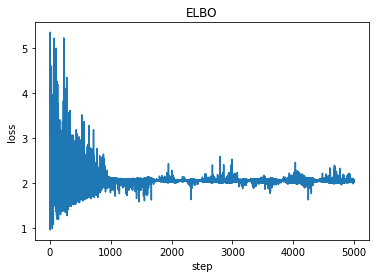

In [176]:
losses, a, b = [], [], []
num_steps = 2500*2
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

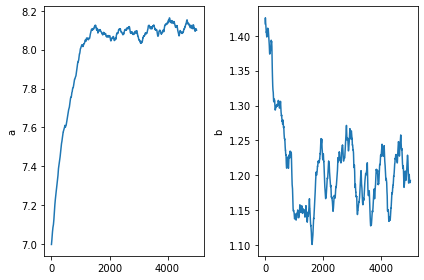

In [178]:
plt.subplot(1,2,1)
# plt.plot([0,num_steps],[7.1,7.1], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
# plt.plot([0,num_steps],[0.91,0.91], 'k:')
plt.plot(b)
plt.tight_layout()

How to incorporate multiple observes?
* https://pyro.ai/examples/effect_handlers.html

In [173]:
pyro.condition

<function pyro.poutine.handlers._make_handler.<locals>.handler>